# Bounding box tool

Building on initial proof of concept in [bounding-box-chad](bounding-box-chad.ipynb) notebook.

This notebook is for investigative purposes only, and serves as a visual documentation on finding the bounding box values.  
The Python code will include only the final results stored  in `download/static_data/country_bbox.csv` file.

In [1]:
!git clone git@github.com:mapaction/geocint-mapaction.git

Cloning into 'geocint-mapaction'...
remote: Enumerating objects: 1510, done.
remote: Counting objects: 100% (179/179), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 1510 (delta 127), reused 124 (delta 92), pack-reused 1331
Receiving objects: 100% (1510/1510), 48.32 MiB | 4.72 MiB/s, done.
Resolving deltas: 100% (787/787), done.


In [2]:
from typing import List, Union
import os

import pandas as pd
import geopandas as gpd

In [3]:
countries_path = "./geocint-mapaction/static_data/countries_world/"
countries_list = os.listdir(countries_path)
print(len(countries_list))
countries_list[:5]

216


['aze.json', 'rwa.json', 'ken.json', 'irq.json', 'chl.json']

In [4]:
def get_world_gdf(src_path: str, county_list: List[str]) -> gpd.GeoDataFrame:
    country_gdf_list: List[gpd.GeoDataFrame] = []

    for country in county_list:
        file_path: str = src_path + country
        gdf: gpd.GeoDataFrame = gpd.read_file(file_path)
        country_gdf_list.append(gdf)

    world_gdf: gpd.GeoDataFrame = (
        pd.concat(country_gdf_list, ignore_index=True)
        .sort_values("iso")
        .reset_index(drop=True)
    )

    return world_gdf

In [5]:
%%time
world_gdf = get_world_gdf(countries_path, countries_list)

CPU times: user 1min 19s, sys: 513 ms, total: 1min 20s
Wall time: 1min 20s


In [6]:
print(type(world_gdf))
print(len(world_gdf))
world_gdf.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
216


,iso,name_en,geometry
0,AFG,Afghanistan,"POLYGON ((60.51759 34.06176, 60.51933 34.06627..."
1,AGO,Angola,"MULTIPOLYGON (((11.46097 -16.55432, 11.46165 -..."
2,AIA,Anguilla,"POLYGON ((-63.63921 18.57656, -63.63618 18.617..."
3,ALB,Albania,"POLYGON ((19.00098 40.50217, 19.00099 40.50396..."
4,AND,Andorra,"POLYGON ((1.41357 42.53538, 1.41387 42.53601, ..."


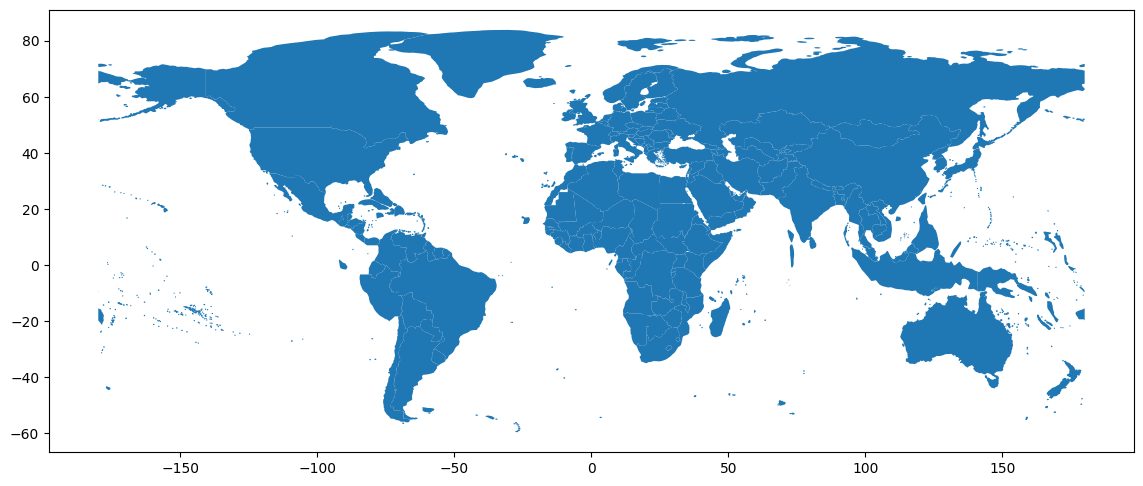

In [7]:
world_gdf.plot(figsize=(14, 7));

In [8]:
world_gdf[world_gdf["name_en"].isin(["Chad", "Ethiopia"])]

,iso,name_en,geometry
59,ETH,Ethiopia,"POLYGON ((32.99757 7.94406, 32.99778 7.94482, ..."
185,TCD,Chad,"POLYGON ((13.47347 14.44282, 13.47508 14.45201..."


In [9]:
def get_bounding_box_str(row: gpd.GeoSeries, buffer_aoi: float = 0.1) -> str:
    bounding_box: np.ndarray = row["geometry"].bounds
    bounding_box_str: str = "/".join(
        [
            str(round(coord, 1))
            for coord in [
                bounding_box[3] + buffer_aoi,
                bounding_box[0] - buffer_aoi,
                bounding_box[1] - buffer_aoi,
                bounding_box[2] + buffer_aoi,
            ]
        ]
    )

    return bounding_box_str

In [10]:
%%time
world_gdf["bbox"] = world_gdf.apply(
    lambda row: get_bounding_box_str(row), axis=1
)

CPU times: user 22 ms, sys: 4.03 ms, total: 26.1 ms
Wall time: 28.2 ms


In [11]:
world_gdf.head()

,iso,name_en,geometry,bbox
0,AFG,Afghanistan,"POLYGON ((60.51759 34.06176, 60.51933 34.06627...",38.6/60.4/29.3/75.0
1,AGO,Angola,"MULTIPOLYGON (((11.46097 -16.55432, 11.46165 -...",-4.3/11.4/-18.1/24.2
2,AIA,Anguilla,"POLYGON ((-63.63921 18.57656, -63.63618 18.617...",18.9/-63.7/18.0/-62.6
3,ALB,Albania,"POLYGON ((19.00098 40.50217, 19.00099 40.50396...",42.8/18.9/39.5/21.2
4,AND,Andorra,"POLYGON ((1.41357 42.53538, 1.41387 42.53601, ...",42.8/1.3/42.3/1.9


### Note

Some country names can be quite long, so we use the `iso` code for country selection.

In [12]:
world_gdf[world_gdf["name_en"].str.split().apply(len) > 5]

,iso,name_en,geometry,bbox
167,SGS,South Georgia and the South Sandwich Islands,"MULTIPOLYGON (((-26.86025 -58.44791, -26.86019...",-53.2/-42.5/-59.8/-25.8
168,SHN,"Saint Helena, Ascension and Tristan da Cunha","MULTIPOLYGON (((-5.99735 -15.99900, -5.99732 -...",-7.6/-14.7/-40.7/-5.3


### Export static data

In [13]:
export_df = world_gdf[["iso", "name_en", "bbox"]]
print(len(export_df))
export_df.head()

216


,iso,name_en,bbox
0,AFG,Afghanistan,38.6/60.4/29.3/75.0
1,AGO,Angola,-4.3/11.4/-18.1/24.2
2,AIA,Anguilla,18.9/-63.7/18.0/-62.6
3,ALB,Albania,42.8/18.9/39.5/21.2
4,AND,Andorra,42.8/1.3/42.3/1.9


In [14]:
export_df.to_csv(
    "../src/data_retrieval/static_data/country_bbox.csv", index=False
)

### Test static data

In [15]:
test_df = pd.read_csv("../src/data_retrieval/static_data/country_bbox.csv")

In [16]:
test_df.head()

,iso,name_en,bbox
0,AFG,Afghanistan,38.6/60.4/29.3/75.0
1,AGO,Angola,-4.3/11.4/-18.1/24.2
2,AIA,Anguilla,18.9/-63.7/18.0/-62.6
3,ALB,Albania,42.8/18.9/39.5/21.2
4,AND,Andorra,42.8/1.3/42.3/1.9


In [17]:
test_df[test_df["name_en"].isin(["Chad", "Ethiopia"])]

,iso,name_en,bbox
59,ETH,Ethiopia,15.0/32.9/3.3/48.1
185,TCD,Chad,23.6/13.4/7.3/24.1


### Clean up

In [18]:
!rm -rf geocint-mapaction